## Reweighihg
In this example, we will demonstrate how to use the Reweighing and ReweighingWithMean methods from the FairLib library to preprocess a dataset for fairness.

In [1]:
import openml
from fairlib import DataFrame
from fairlib.preprocessing import Reweighing, ReweighingWithMean
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def prepare_dataset():
    """
    Load and preprocess the dataset.
    """
    dataset = openml.datasets.get_dataset(179)  # Adult dataset
    X, y, _, names = dataset.get_data(target=dataset.default_target_attribute)

    for col in X.columns:
        if X[col].dtype.name == 'category':
            X[col] = X[col].astype(object)

        # Fill missing values
        if X[col].isna().any():
            X[col] = X[col].fillna("missing")

        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

    X = DataFrame(X)
    X = X.drop(columns=["fnlwgt"])  # Drop unnecessary column
    y = y.apply(lambda x: x == ">50K").astype(int)  # Convert to binary target

    return X, y

In [3]:
def evaluate_fairness(X_test, y_pred):
    """
    Evaluate the fairness metrics (SPD and DI) of the predictions.
    """
    X_test = X_test.copy()
    X_test["income"] = y_pred
    dataset = DataFrame(X_test)
    dataset.targets = "income"
    dataset.sensitive = "sex"

    spd = dataset.statistical_parity_difference()
    di = dataset.disparate_impact()
    return spd, di

In [4]:
def train_classifier(X_train, y_train, sample_weight=None):
    """
    Train a logistic regression classifier with optional sample weights.
    """
    clf = LogisticRegression(random_state=42, max_iter=1000)
    clf.fit(X_train, y_train, sample_weight=sample_weight)
    return clf

In [5]:
np.random.seed(42)

TARGET = "income"
SENSITIVE = "sex"

# Prepare dataset
X, y = prepare_dataset()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=42
)

## Training a baseline model without fairness preprocessing

In [6]:
# Train a baseline classifier without fairness preprocessing
baseline_clf = train_classifier(X_train, y_train)

# Evaluate the baseline model
baseline_pred = baseline_clf.predict(X_test)
baseline_accuracy = accuracy_score(y_test, baseline_pred)
baseline_spd, baseline_di = evaluate_fairness(X_test, baseline_pred)

print(f"Baseline Model Accuracy: {baseline_accuracy:.4f}")
print(f"Baseline Statistical Parity Difference: {baseline_spd}")
print(f"Baseline Disparate Impact: {baseline_di}")

Baseline Model Accuracy: 0.8240
Baseline Statistical Parity Difference: {(income=0, sex=0): 0.1681490872919421, (income=0, sex=1): -0.1681490872919421, (income=1, sex=0): -0.1681490872919421, (income=1, sex=1): 0.1681490872919421}
Baseline Disparate Impact: {(income=0, sex=0): 0.8250140816862976, (income=0, sex=1): 1.2121005231280875, (income=1, sex=0): 5.303707720688356, (income=1, sex=1): 0.18854734322920272}


## Applying Reweighing for fairness preprocessing

In [7]:
# Prepare data for Reweighing
X_train_with_target = X_train.copy()
X_train_with_target[TARGET] = y_train
train_dataset = DataFrame(X_train_with_target)
train_dataset.targets = TARGET
train_dataset.sensitive = SENSITIVE

# Apply Reweighing
reweighing = Reweighing()
reweighed_df = reweighing.fit_transform(train_dataset)

# Extract weights and features for training
weights = reweighed_df['weights'].values
X_train_reweighed = X_train.copy()

# Train a classifier with the reweighed data
reweighed_clf = train_classifier(X_train_reweighed, y_train, sample_weight=weights)

# Evaluate the reweighed model
reweighed_pred = reweighed_clf.predict(X_test)
reweighed_accuracy = accuracy_score(y_test, reweighed_pred)
reweighed_spd, reweighed_di = evaluate_fairness(X_test, reweighed_pred)

print(f"Reweighed Model Accuracy: {reweighed_accuracy:.4f}")
print(f"Reweighed Statistical Parity Difference: {reweighed_spd}")
print(f"Reweighed Disparate Impact: {reweighed_di}")

Reweighed Model Accuracy: 0.8164
Reweighed Statistical Parity Difference: {(income=0, sex=0): 0.09104925920912543, (income=0, sex=1): -0.09104925920912543, (income=1, sex=0): -0.09104925920912545, (income=1, sex=1): 0.09104925920912545}
Reweighed Disparate Impact: {(income=0, sex=0): 0.9011763341306112, (income=0, sex=1): 1.1096607424391882, (income=1, sex=0): 2.1573644090072723, (income=1, sex=1): 0.46352855170173013}


## Applying ReweighingWithMean for fairness preprocessing

In [8]:
# Apply ReweighingWithMean
reweighing_mean = ReweighingWithMean()
reweighed_mean_df = reweighing_mean.fit_transform(train_dataset)

# Extract weights and features for training
weights_mean = reweighed_mean_df['weights'].values
X_train_reweighed_mean = X_train.copy()

# Train a classifier with the reweighed data
reweighed_mean_clf = train_classifier(X_train_reweighed_mean, y_train, sample_weight=weights_mean)

# Evaluate the reweighed model
reweighed_mean_pred = reweighed_mean_clf.predict(X_test)
reweighed_mean_accuracy = accuracy_score(y_test, reweighed_mean_pred)
reweighed_mean_spd, reweighed_mean_di = evaluate_fairness(X_test, reweighed_mean_pred)

print(f"ReweighingWithMean Model Accuracy: {reweighed_mean_accuracy:.4f}")
print(f"ReweighingWithMean Statistical Parity Difference: {reweighed_mean_spd}")
print(f"ReweighingWithMean Disparate Impact: {reweighed_mean_di}")

ReweighingWithMean Model Accuracy: 0.8119
ReweighingWithMean Statistical Parity Difference: {(income=0, sex=0): 0.056612544658975694, (income=0, sex=1): -0.056612544658975694, (income=1, sex=0): -0.05661254465897572, (income=1, sex=1): 0.05661254465897572}
ReweighingWithMean Disparate Impact: {(income=0, sex=0): 0.9371242222923574, (income=0, sex=1): 1.067094389635814, (income=1, sex=0): 1.568325934191343, (income=1, sex=1): 0.6376225618660181}


## Comparing Results

Comparison of Models:
                Model  Accuracy       SPD        DI
0            Baseline  0.823984  0.168149  0.174986
1          Reweighing  0.816438  0.091049  0.098824
2  ReweighingWithMean  0.811933  0.056613  0.062876


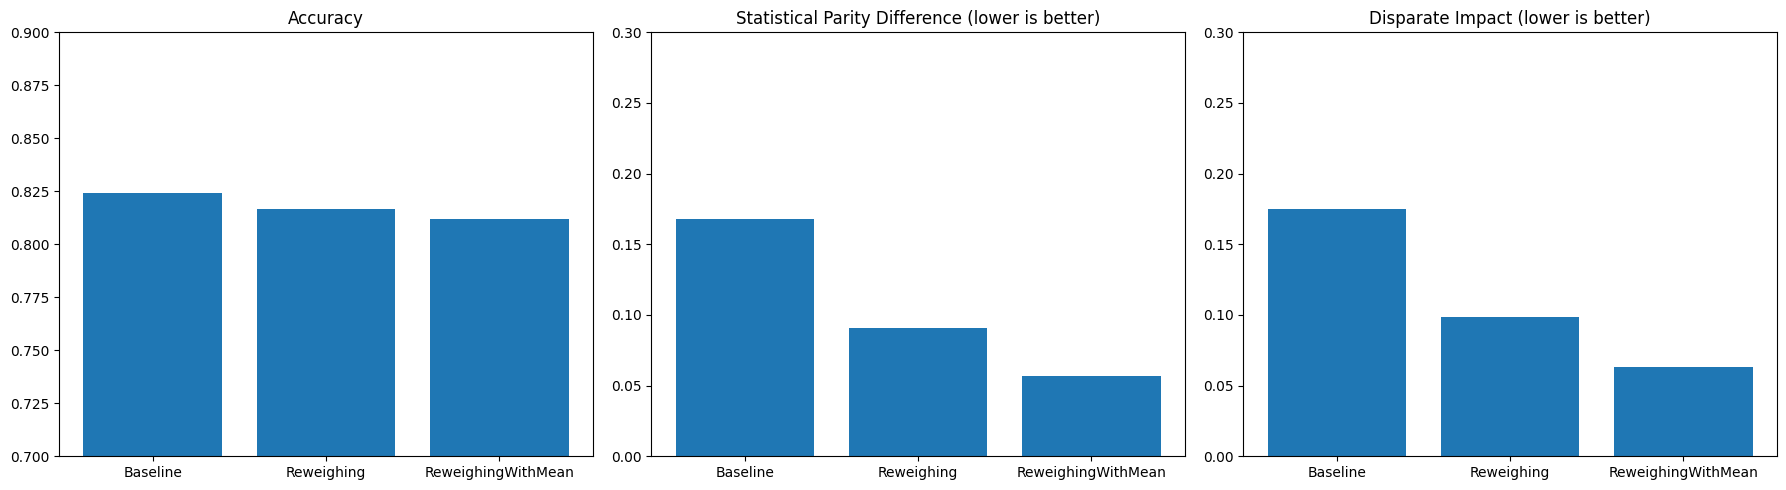

In [9]:
# Create a comparison table
results = pd.DataFrame({
    'Model': ['Baseline', 'Reweighing', 'ReweighingWithMean'],
    'Accuracy': [baseline_accuracy, reweighed_accuracy, reweighed_mean_accuracy],
    'SPD': [abs(list(baseline_spd.values())[0]), abs(list(reweighed_spd.values())[0]), abs(list(reweighed_mean_spd.values())[0])],
    'DI': [abs(list(baseline_di.values())[0] - 1), abs(list(reweighed_di.values())[0] - 1), abs(list(reweighed_mean_di.values())[0] - 1)]
})

print("Comparison of Models:")
print(results)

# Visualize the results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy comparison
ax1.bar(results['Model'], results['Accuracy'])
ax1.set_title('Accuracy')
ax1.set_ylim(0.7, 0.9)  # Adjust as needed

# SPD comparison (lower is better)
ax2.bar(results['Model'], results['SPD'])
ax2.set_title('Statistical Parity Difference (lower is better)')
ax2.set_ylim(0, 0.3)  # Adjust as needed

# DI comparison (lower is better)
ax3.bar(results['Model'], results['DI'])
ax3.set_title('Disparate Impact (lower is better)')
ax3.set_ylim(0, 0.3)  # Adjust as needed

plt.tight_layout()
plt.show()